In [120]:
import os
import pandas as pd
import random
from tqdm import tqdm
import numpy as np
import torch
from torch.functional import F
from torch import nn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoTokenizer, AutoModel

seed = 10
random.seed(10)
np.random.seed(10)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:0


In [33]:
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    print(os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''))
    kaggle = True

In [34]:
!if [[ -z "${KAGGLE_KERNEL_RUN_TYPE}" ]]; then git clone https://github.com/1-1is0/farstail-nli-task; cp farstail-nli-task/*.py . ; fi

Cloning into 'farstail-nli-task'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 4), reused 18 (delta 2), pack-reused 0
Receiving objects: 100% (20/20), 409.95 KiB | 969.00 KiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython import display
def rtl_print(outputs, font_size="15px", n_to_br=False):
    outputs = outputs if isinstance(outputs, list) else [outputs] 
    if n_to_br:
        outputs = [output.replace('\n', '') for output in outputs]
        
    outputs = [f'{output}' for output in outputs]
    display.display(display.HTML(' '.join(outputs)))


In [4]:
df = pd.read_excel('./data/datasets/sentipers.xlsx', sheet_name=0)
df.head()

,text,polarity
0,اینک قصد داریم پرینتر دیگری از پرینترهای لیزری...,neutral
1,پرینتری چند کاره از رده‌ی Entry Level یا سطح م...,neutral
2,به هر صورت اکنون ما در دنیایی زندگی می‌کنیم، ...,neutral
3,به صورتی که توانایی کپی کردن، اسکن، فکس، پر...,neutral
4,به هر صورت معمولا چیزی که بیشتر کاربران از پری...,very good


In [6]:
label_encoder = LabelEncoder()
df['polarity_id'] = label_encoder.fit_transform(df['polarity'])

In [7]:
df.head()

,text,polarity,polarity_id
9209,این دوربین توانایی ضبط ویدیویی 72neutralp HD د...,very good,4
6833,با وزن تنها 27neutral گرم نیز یکی از سبک وزن ت...,very good,4
15516,ایسوس اعلام کرده است که در ساخت این تبلت از شی...,neutral,2
6989,این قلم نه از نظر ظاهری و نه از لحاظ کارایی، ش...,bad,0
6420,به طور مثال شما می‌توانید تعیین نمایید که در ح...,neutral,2


In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)
val_df, test_df =  train_test_split(test_df, test_size=0.5, random_state=seed)

In [9]:
text = df.iloc[0]["text"]

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = 50

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["text"]
        polarity = row["polarity"]
        polarity_id = row["polarity_id"]
        # Tokenize inputs
        encoded_inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        input_ids = encoded_inputs["input_ids"].squeeze()
        attention_mask = encoded_inputs["attention_mask"].squeeze()
        token_type_id = encoded_inputs["token_type_ids"].squeeze()
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_id,
            "label": polarity,
            "label_id": torch.tensor(polarity_id, dtype=torch.long),
        }

In [11]:
from multiprocessing import cpu_count

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/labse")
train_dataset = Dataset(train_df, tokenizer)
val_dataset = Dataset(val_df, tokenizer)
test_dataset = Dataset(test_df, tokenizer)


batch_size = 32
num_workers = cpu_count() - 2
pin_memory = True if device == "cuda" else False
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [12]:
config = AutoConfig.from_pretrained("sentence-transformers/labse")
model = AutoModel.from_pretrained("sentence-transformers/LaBSE")

In [13]:
class LaBSEModel(nn.Module):
    """Performs prediction, given the input of BERT embeddings."""

    def __init__(
        self,
        label_num=3,
        reinit_num=0,
        freeze_layers=True,
    ):
        super(LaBSEModel, self).__init__()
        # self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.config = AutoConfig.from_pretrained("sentence-transformers/LaBSE")
        # self.tokenizer = AutoTokenizer.from_pretrained(
        #     "sentence-transformers/LaBSE"
        # )
        self.model = AutoModel.from_pretrained("sentence-transformers/LaBSE")

        self.num_hidden_layers = self.config.num_hidden_layers
        self.vdim = self.config.hidden_size

        self.batch_norm = nn.BatchNorm1d(self.vdim)
        self.nli_head1 = nn.Linear(self.vdim, 500)
        self.nli_head2 = nn.Linear(500, 250)
        self.nli_head3 = nn.Linear(250, label_num)
        self.sm = nn.Softmax(dim=1)
        self.reinit(layer_num=reinit_num, freeze=freeze_layers)


    def reinit(self, layer_num, freeze):
        """Reinitialise parameters of last N layers and freeze all others"""
        if freeze:
            for _, pp in self.model.named_parameters():
                pp.requires_grad = False

        # if layer_num >= 0:
        #     layer_idx = [self.num_hidden_layers - 1 - i for i in range(layer_num)]
        #     layer_names = ["encoder.layer.{}".format(j) for j in layer_idx]
        #     for pn, pp in self.model.named_parameters():
        #         if any([ln in pn for ln in layer_names]) or "pooler." in pn:
        #             pp.data = torch.randn(pp.shape) * 0.02
        #             pp.requires_grad = True


    def forward(self, input_ids, attention_mask, token_type_ids, checkpoint=False):
        cls_vecs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )[1]

        out = self.batch_norm(cls_vecs)
        out = F.relu(self.nli_head1(out))
        out = F.relu(self.nli_head2(out))
        logits = self.nli_head3(out)
        probs = self.sm(logits)

        torch.cuda.empty_cache() # releases all unoccupied cached memory

        return logits, probs

In [14]:
model = LaBSEModel(label_num=len(label_encoder.classes_))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4,eps=1e-6)

model/state-LaBSEModel-optimizer-AdamW-loss-CrossEntropyLoss.pth exist


[13s] Epoch 7 loss : 0.62597903 acc: 76.36 val: 1.02078240 acc: 56.69%


[19s] Epoch 8 loss : 0.57098423 acc: 79.25 val: 1.02057861 acc: 57.32%


[31s] Epoch 9 loss : 0.52561621 acc: 81.49 val: 1.04172334 acc: 57.32%


[46s] Epoch 10 loss : 0.45831846 acc: 86.06 val: 1.04972755 acc: 56.69%


[46s] Epoch 11 loss : 0.42505948 acc: 86.22 val: 1.07979587 acc: 56.05%


[47s] Epoch 12 loss : 0.36931435 acc: 89.02 val: 1.11131119 acc: 56.05%


[48s] Epoch 13 loss : 0.33573782 acc: 89.82 val: 1.14583682 acc: 54.78%


[63s] Epoch 14 loss : 0.29223889 acc: 92.31 val: 1.18427210 acc: 55.41%


[92s] Epoch 15 loss : 0.25109427 acc: 94.71 val: 1.21433620 acc: 54.78%


[93s] Epoch 16 loss : 0.22019312 acc: 95.03 val: 1.22433755 acc: 54.78%


[89s] Epoch 17 loss : 0.18589515 acc: 96.15 val: 1.29357467 acc: 54.78%


[92s] Epoch 18 loss : 0.15252902 acc: 97.68 val: 1.32800040 acc: 55.41%


[93s] Epoch 19 loss : 0.12930773 acc: 97.76 val: 1.36472607 acc: 54.78%


[93s] Epoch 20 loss : 0.10823094 acc: 98.56 val: 1.42437147 acc: 56.05%


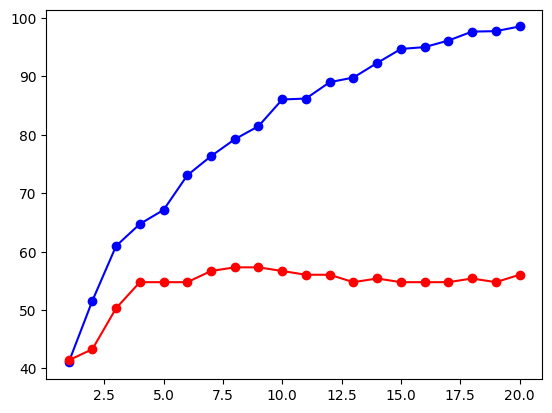

In [15]:

from train import train
from easydict import EasyDict

dataset = EasyDict(
    {
        "train": train_dataset,
        "val": test_dataset,
        "test": test_dataset,
    }
)
data_loader = EasyDict(
    {
        "train": train_loader,
        "val": test_loader,
        "test": test_loader,
    }
)



start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [80]:
from tools import evaluate_loader, show_cm, plot_metrics, plot_cm
labels = label_encoder.transform(label_encoder.classes_)
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device, labels=labels)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 1.43258798122406
accuracy 0.559698275862069
precision 0.559698275862069
recall 0.559698275862069
f1 0.559698275862069
[[ 8  2  9  0  0]
 [ 0 23 15  0 10]
 [ 8  9 40  0  3]
 [ 0  0  0  0  0]
 [ 0 12  1  0 17]]


In [81]:
plot_metrics(metrics)

Metrics,Value
loss,1.43259
accuracy,0.559698
precision,0.559698
recall,0.559698
f1,0.559698


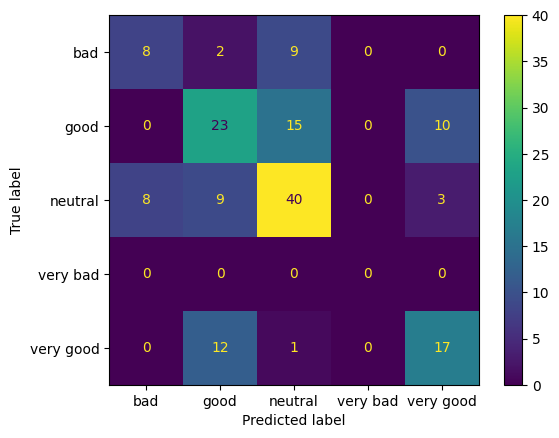

In [82]:
plot_cm(cm, label_encoder.classes_)

In [94]:

snap_food_df = pd.read_csv("data/datasets/snapfood_testset.csv")
snap_food_df.columns = ["text", "polarity"]
snap_food_df.polarity = snap_food_df.polarity.str.lower()

snap_label_encoder = LabelEncoder()
snap_food_df["polarity_id"] = snap_label_encoder.fit_transform(snap_food_df["polarity"])
snap_food_df.head()

,text,polarity,polarity_id
0,خواهشا خواهشا خواهشا واسه ارسال شیرینیها یه فک...,happy,0
1,غذا گرم رسید کیفیت و پخت گوشت عالی بود,happy,0
2,قیمت سس شکلات روی بسته بندی ۱۵۰۰۰ بود ولی قیمت...,sad,1
3,عکس توی پیج یه شیرینی شکری روشن رنگ هست که همم...,sad,1
4,باز هم میگم، پیتزا نباید اینقد چرب باشه,sad,1


In [130]:
map_sentiment = {
    "bad": "sad",
    "very bad": "sad",
    "good": "happy",
    "very good": "happy",
    "neutral": "happy",
}
map_id = {}
for k, v in map_sentiment.items():
    map_id[label_encoder.transform([k])[0]] = snap_label_encoder.transform([v])[0]
map_id

{0: 1, 3: 1, 1: 0, 4: 0, 2: 0}

In [131]:
snap_dataset = Dataset(snap_food_df, tokenizer)
snap_dataloader = torch.utils.data.DataLoader(
    snap_dataset, 
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [132]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


def compute_loss(y, predictions, loss):
    # loss
    # binarize predictions from predictions (outputs = 1 if p>0.5 else 0)
    outputs = torch.argmax(predictions, axis=1)
    outputs = [map_id[i.item()] for i in outputs]
    # metrics with accuracy, precision, recall, f1
    accuracy = accuracy_score(y.cpu(), outputs)
    precision, recall, f1 = [metric(y.cpu(), outputs, average="micro") for metric in [precision_score, recall_score, f1_score]]
    return loss, accuracy, precision, recall, f1
    
def evaluate_loader(loader, model, criterion, device):
    model.eval()
    # compute loss and accuracy for that loader
    metrics = {
        "loss": 0,
        "accuracy": 0,
        "precision": 0,
        "recall": 0,
        "f1": 0,
    }
    with torch.no_grad():
        # loop over examples of loader
        for i, data in enumerate(loader):

            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            token_type_ids = data["token_type_ids"].to(device)
            label_id = data["label_id"].to(device)
            logits, probs = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(logits, label_id)
            loss, accuracy, precision, recall, f1 = compute_loss(label_id, probs, loss)
            # sum up metrics in dict
            metrics["loss"] += loss.item()
            metrics["accuracy"] += accuracy
            metrics["precision"] += precision
            metrics["recall"] += recall
            metrics["f1"] += f1
        # normalize all values
        for k in metrics.keys():
            metrics[k] /= len(loader)
        return metrics

def show_cm(model, loader, device, labels=None):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader)):

            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            token_type_ids = data["token_type_ids"].to(device)
            label_id = data["label_id"]
            now_batch_size = label_id.size(0)
            logits, probs = model(input_ids, attention_mask, token_type_ids)

            outputs = torch.argmax(probs, axis=1)
            outputs = [map_id[i.item()] for i in outputs]
            y_true.extend(label_id.tolist())
            y_pred.extend(outputs)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return cm

In [135]:
model.eval()
labels = snap_label_encoder.transform(snap_label_encoder.classes_)
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device, labels=labels)

for key, val in metrics.items():
    print(key, val)

print(cm)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 5/5 [00:09<00:00,  2.03s/it]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

loss 1.43258798122406
accuracy 0.07198275862068966
precision 0.07198275862068966
recall 0.07198275862068966
f1 0.07198275862068966
[[11  8]
 [48  0]]


In [136]:
plot_metrics(metrics)

Metrics,Value
loss,1.43259
accuracy,0.0719828
precision,0.0719828
recall,0.0719828
f1,0.0719828


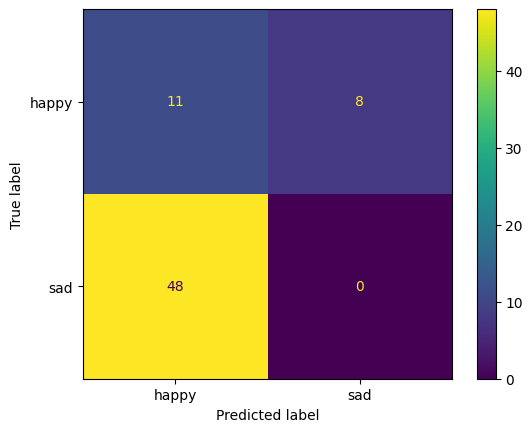

In [137]:
plot_cm(cm, snap_label_encoder.classes_)

In [ ]:

map_sentiment = {
    "bad": "sad",
    "very bad": "sad",
    "good": "happy",
    "very good": "happy",
    "neutral": "sad",
}
map_id = {}
for k, v in map_sentiment.items():
    map_id[label_encoder.transform([k])[0]] = snap_label_encoder.transform([v])[0]
map_id

In [138]:
model.eval()
labels = snap_label_encoder.transform(snap_label_encoder.classes_)
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device, labels=labels)

for key, val in metrics.items():
    print(key, val)

print(cm)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]

loss 1.43258798122406
accuracy 0.07198275862068966
precision 0.07198275862068966
recall 0.07198275862068966
f1 0.07198275862068966
[[11  8]
 [48  0]]


In [139]:
plot_metrics(metrics)

Metrics,Value
loss,1.43259
accuracy,0.0719828
precision,0.0719828
recall,0.0719828
f1,0.0719828


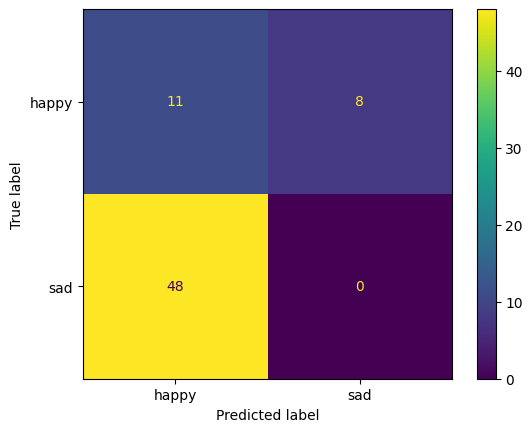

In [140]:
plot_cm(cm, snap_label_encoder.classes_)